# TMD maps with one-D potential 

Here we will aim to measure the effect of prefactor reduction in a 1D case of TMD map. Note that our error model is of the form: 

$$ |4L^{(n)}_{\epsilon,\mu}f(x) - \mathcal{L}f(x)| \sim \frac{V(x)\sqrt{\log n}}{\sqrt{n}\epsilon^{2 + d/2}} + \epsilon B(x) $$

Here $V$ and $B$ are variance and bias error prefactors respectively. The 1-D setup is as follows: 

1. $V: \mathbb{R} \to \mathbb{R}$ is a (coercive) potential. 
2. The system $X_t$ is governed by the SDE: 
$\begin{align}dX_t = -\nabla V(X_t) + \sqrt{2\beta^{-1}} dW_t \end{align} $
3. The ergodic measure is $\propto \exp{\left(-\beta V(x)\right)}$
4. The committor satisfies: 
$$\begin{align}\Delta q - \beta\nabla V(x) \cdot \nabla q(x) = 0,\:\: q\mid_{\partial A} = 0\, q\mid_{\partial B} = 1 \end{align}$$

Here $A = [\theta_1-r, \theta_1+r]$ and $B = [\theta_2-r, \theta_2+r]$. The committor function can be given analytically for $x$: 

$$\begin{align}
    q(\theta) = \begin{cases} \frac{\int_{\theta_{1}+r}^{\theta}\exp{\left(\beta V(\theta')\right)}\,d\theta'}{\int_{\theta_{1}+r}^{\theta_{2}-r}\exp{\left(\beta V(\theta')\right)}\,d\theta'}, \quad &\theta \in [\theta_1 + r, \theta_2 - r], \\
     \frac{\int_{\theta}^{2\pi}\exp{\left(\beta V(\theta')\right) }\,d\theta'+\int_{0}^{\theta_1-r}\exp{\left(\beta V(\theta')\right)}\,d\theta'}{\int_{\theta_{2}+r}^{2\pi}\exp{\left(\beta V(\theta')\right)}\,d\theta'  +\int_{0}^{\theta_1-r}\exp{\left(\beta V(\theta')\right)}\,d\theta'
    }, \quad &\theta \in [\theta_2 + r, 2\pi) \\
     \frac{\int_{\theta}^{\theta_1-r}\exp{\left(\beta V(\theta')\right)}\,d\theta'}{\int_{\theta_{2}+r}^{2\pi}\exp{\left(\beta V(\theta')\right)}\,d\theta'    +\int_{0}^{\theta_1-r}\exp{\left(\beta V(\theta')\right)}\,d\theta'
    }, \quad &\theta \in [0, \theta_1-r]
    \end{cases}
\end{align}$$

A good 1-D potential is 

$$ \begin{align}
    V(\theta) = \left(4\cos^2\left(\frac{1}{2}\theta\right)- \frac{3}{2}\right)^2
\end{align} $$

We set 

$$ \theta_1 = 2\arccos{\left(-\frac{\sqrt{3/2}}{2}\right)} \qquad \theta_1 = 2\arccos{\left(\frac{\sqrt{3/2}}{2}\right)}$$

and $r = 0.1$. 

In [1]:
import os
import copy
import sys 
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__),'..')))
sys.path.append("..")
sys.path.append("..")

# Regular Modules
import scipy.sparse as sps
import numpy as np
import sklearn as sklearn
import matplotlib.pyplot as plt
import datetime
import scipy.integrate as scint
#from numpy.random import default_rng
import numpy.ma as ma
import matplotlib.tri as tri
import scipy.io
import time 
from mpl_toolkits.mplot3d import axes3d
import argparse

# parallelization modules 
from math import nan
from joblib import Parallel, delayed
import multiprocess
import itertools
import tqdm

# # My Modules
# import src.model_systems as model_systems
# import src.helpers as helpers
# import src.potentials as potentials
# import src.diffusion_map as diffusion_map
# from src.fem.distmesh import * 
# from src.fem.FEM_TPT import *
# import src.sampling as sampling
from datetime import date

In [2]:
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 24}

plt.rc('font', **font)

How to do this: 

1. Set up drift, potential, invariant measure, committor. 

2. Set up two datasets: uniform, normal random variable centered @ 0. 

3. Set up TMD map kernel for each set. This will involve picking epsilon, N. Don't use knn sparsification. Compare KDE's. 

4. Approximate $\mathcal{L}$ on some simple $f$ (say $f = x^5 - x$) by plugging in the analytical form for $\mathcal{L}f = f'' - V'(x)f'(x)$.

5. Note that $4\mathcal{L}_{\epsilon,\mu}f(x) \approx \mathcal{L}$. DONT FORGET THE FACTOR OF 4!!!

## Define potential, drift

In [3]:
# set up params
beta = 1
d = 1
def potential(x): 
    return (4*(np.cos(x/2))**2 - 3/2)**2

def drift(x): 
    return -4*np.sin(x/2)*np.cos(x/2)*(8*(np.cos(x/2))**2 - 3)

Z = scint.quad(lambda x: np.exp(-beta*potential(x)), 0, 2*np.pi)[0]

def mu(x): return (1/Z)*np.exp(-beta*potential(x))

## Define $\theta,r$

In [4]:
theta_2 = 2*np.arccos(-(np.sqrt(3/2)/2))
theta_1 = 2*np.arccos((np.sqrt(3/2)/2))
r = 0.1

## Define $f$

In [5]:
def f(x): return np.sin(x)
def Lf(x): return -np.sin(x) - beta*drift(x)*np.cos(x)

## Define committor 

In [6]:
Z_committor_12 = scint.quad(lambda x: np.exp(beta*potential(x)), theta_1+r,theta_2-r)[0]
Z_committor_21 = scint.quad(lambda x: np.exp(beta*potential(x)), theta_2+r, 2*np.pi)[0] + \
                 scint.quad(lambda x: np.exp(beta*potential(x)), 0, theta_1-r)[0]

# def committor(x):
#     # x = 2*np.pi*(x%1.0) # rescale to [0,2pi] interval 
#     if 0.0 <= x < theta_1 - r: 
#         committor = (1/Z_committor_21)*scint.quad(lambda y: np.exp(beta*potential(y)), x, theta_1 - r)[0]
#         return committor 
#     elif theta_1-r <= x < theta_1+r:
#         return 0.0
#     elif theta_1+r <= x < theta_2-r: 
#         committor = (1/Z_committor_12)*scint.quad(lambda y: np.exp(beta*potential(y)), theta_1 + r, x)[0]
#         return committor 
#     elif theta_2-r <= x < theta_2+r: 
#         return 1.0
#     else: 
#         committor = (1/Z_committor_21)*scint.quad(lambda x: np.exp(beta*potential(x)), 0, theta_1-r)[0] + \
#                     (1/Z_committor_21)*scint.quad(lambda y: np.exp(beta*potential(y)), x, 2*np.pi)[0]
#         return committor 

Z_01 = scint.quad(lambda x: np.exp(beta*potential(x)), 0,theta_1-r)[0] + scint.quad(lambda x: np.exp(beta*potential(x)), theta_2+r, 2*np.pi)[0]
Z_12 = scint.quad(lambda x: np.exp(beta*potential(x)),theta_1+r, theta_2-r)[0]
Z_23 = scint.quad(lambda x: np.exp(beta*potential(x)), 0,theta_1-r)[0] + scint.quad(lambda x: np.exp(beta*potential(x)), theta_2+r, 2*np.pi)[0]

def committor(x):
    # x = 2*np.pi*(x%1.0) # rescale to [0,2pi] interval 
    if 0.0 <= x < theta_1 - r: 
        committor = (1/Z_01)*scint.quad(lambda y: np.exp(beta*potential(y)), x, theta_1 - r)[0]
        return committor 
    elif theta_1-r <= x < theta_1+r:
        return 0.0
    elif theta_1+r <= x < theta_2-r: 
        committor = (1/Z_12)*scint.quad(lambda y: np.exp(beta*potential(y)), theta_1 + r, x)[0]
        return committor 
    elif theta_2-r <= x < theta_2+r: 
        return 1.0
    else: 
        committor = (1/Z_23)*(scint.quad(lambda y: np.exp(beta*potential(y)), 0,theta_1-r)[0] \
                    + scint.quad(lambda y: np.exp(beta*potential(y)), x, 2*np.pi)[0])
        return committor 

## Plot the potential 

In [7]:
t = np.linspace(0,2*np.pi,1000)
y = np.zeros(t.shape)
for i in range(t.shape[0]):
    y[i] = potential(t[i])

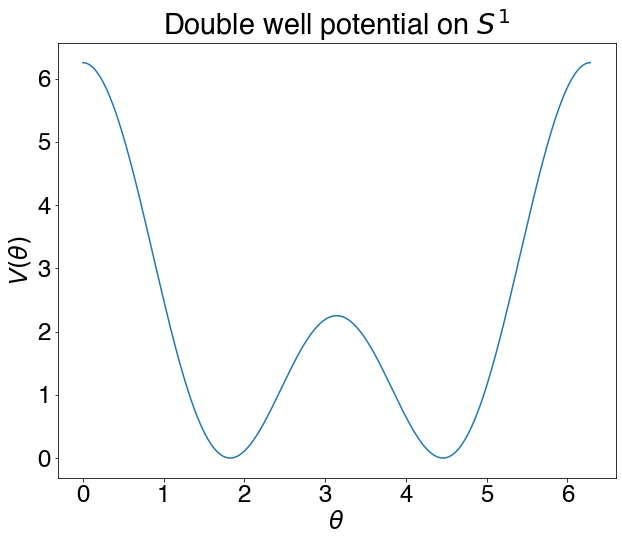

In [8]:
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(t,y)
ax.set_title(r"Double well potential on $S^1$")
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$V(\theta)$")
fig.savefig("circular_potential.pdf", bbox_inches="tight")

## Plot mu 

In [9]:
t = np.linspace(0,2*np.pi,1000)
y = np.zeros(t.shape)
for i in range(t.shape[0]):
    y[i] = mu(t[i])

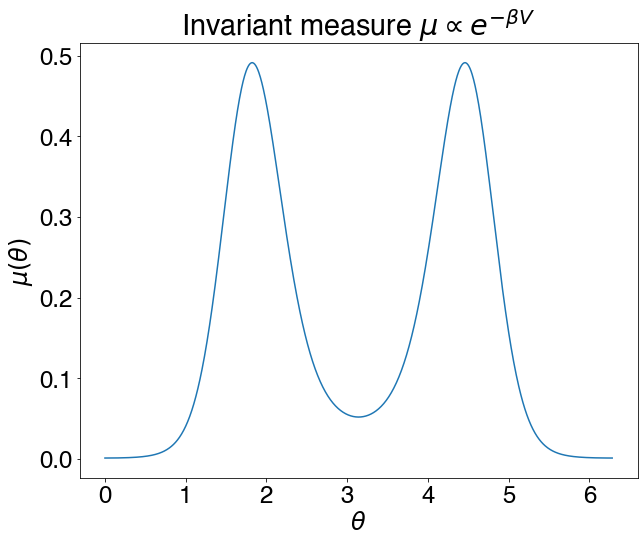

In [10]:
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(t,y)
ax.set_title(r"Invariant measure $\mu \propto e^{-\beta V}$")
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\mu(\theta)$")
fig.savefig("circular_mu.pdf", bbox_inches="tight")

## Plot the committor

In [11]:
t = np.linspace(0,2*np.pi,45)
y = np.zeros(t.shape)
for i in range(t.shape[0]):
    y[i] = committor(t[i])

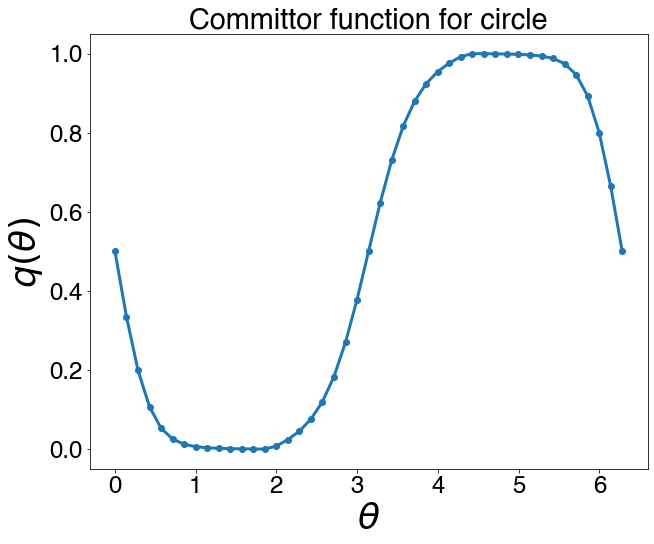

In [12]:
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(t,y, linewidth=3.0, marker='o')
ax.set_title("Committor function for circle")
ax.set_xlabel(r"$\theta$", fontsize=36)
ax.set_ylabel(r"$q(\theta)$", fontsize=36)
# ax.set_xlim((theta_1+r-0.5, theta_1+r+0.5))
# ax.set_ylim((0.0,0.01))
fig.savefig("circular_committor.pdf", bbox_inches="tight")

## Plot f 

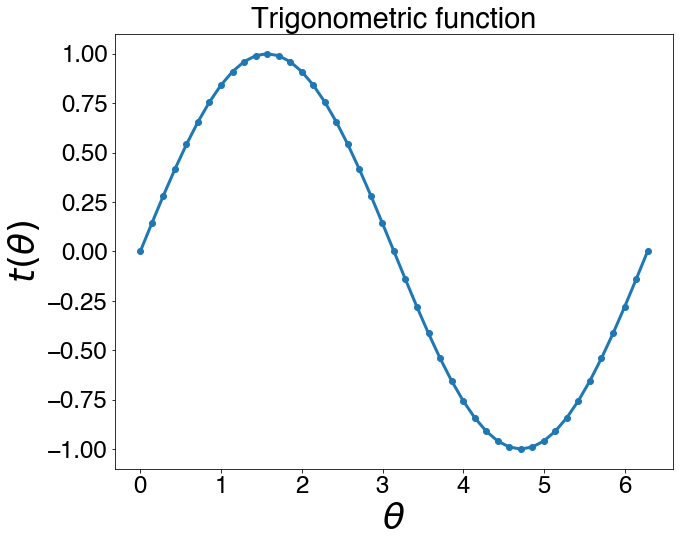

In [13]:
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(t,f(t), linewidth=3.0, marker='o')
ax.set_ylabel(r"$t(\theta)$", fontsize=36)
ax.set_xlabel(r"$\theta$", fontsize=36)
ax.set_title("Trigonometric function")
fig.savefig("circular_trig.pdf", bbox_inches="tight")

## Plot the two different densities 

In [19]:
N = int(1e4)
sig = 0.2
biased = 0.6 + sig*np.random.randn(int(N+1)).reshape(N+1,d) # p = biased[N]
biased = 2*np.pi*(biased % 1.0) 
biased[N,0] = np.pi
normal_rnd = (1/(2*np.pi)**(d/2))*np.exp(-((biased-np.pi)**2)/2)

uniform = np.random.uniform(0.0,2*np.pi,N+1).reshape(N+1,d)
uniform[N,0] = np.pi
uniform_rnd = (1/2*np.pi)*np.ones(uniform.shape)

Text(0.5, 0, 'x')

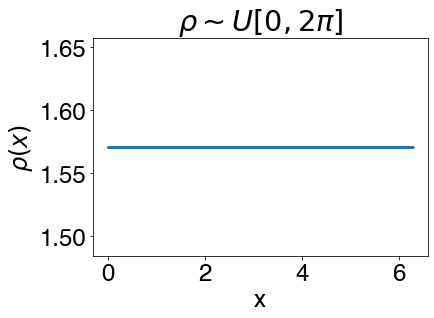

In [20]:
# uniform 

plt.scatter(uniform,uniform_rnd,s=1.0)
plt.title(r"$\rho \sim U[0,2\pi]$")
plt.ylabel(r"$\rho(x)$")
plt.xlabel("x")

Text(0.5, 0, 'x')

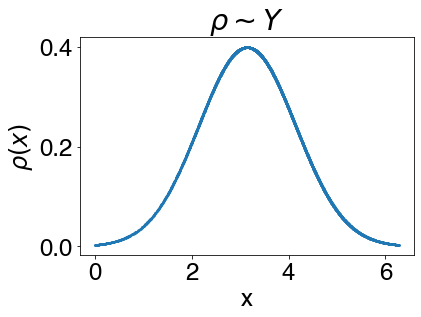

In [21]:
# biased 

plt.scatter(biased,normal_rnd,s=1.0)
plt.title(r"$\rho \sim Y$")
plt.ylabel(r"$\rho(x)$")
plt.xlabel("x")

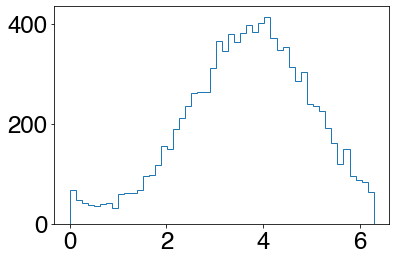

In [22]:
count, bins = np.histogram(biased, bins=50)
plt.stairs(count,bins)

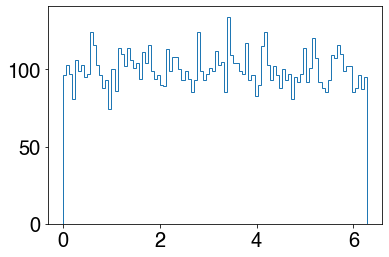

In [100]:
count, bins = np.histogram(uniform, bins=100)
plt.stairs(count,bins)

In [101]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [102]:
x = np.cos(bins[:-1])
y = np.sin(bins[:-1])
z = count/np.sum(count)

In [103]:
# Code to convert data in 3D polygons
v = []
h = 0.0 
for k in range(0, len(x)-1):
    xs = [x[k], x[k+1], x[k+1], x[k]]
    ys = [y[k], y[k+1], y[k+1], y[k]]
    zs = [z[k], z[k],       h,     h]
    v.append(list(zip(xs, ys, zs)))    
    #list is necessary in python 3/remove for python 2

k=k+1
xs = [x[k], x[0], x[0], x[k]]
ys = [y[k], y[0], y[0], y[k]]
zs = [z[k], z[k],       h,     h]
v.append(list(zip(xs, ys, zs)))
poly3dCollection = Poly3DCollection(v, alpha=0.4)

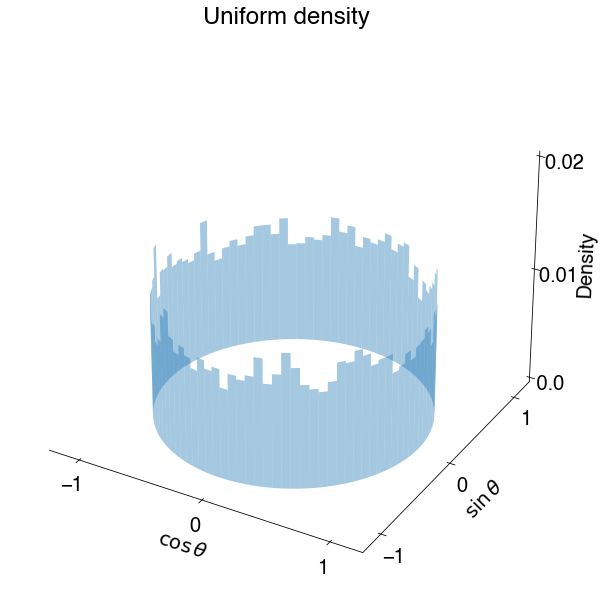

In [104]:
# Code to plot the 3D polygons
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(projection='3d')
ax.add_collection3d(poly3dCollection)
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
ax.set_zlim([0.0, 0.04])
ax.set_xlabel("\n"+ r"$\cos \theta $")
ax.set_ylabel("\n"+ r"$\sin \theta$")
ax.set_zlabel("\n"+ "Density")
# ax.xticks(fontsize=14, rotation=90)

ax.set_xticks([-1.0,0.0,1.0])
ax.set_yticks([-1.0,0.0,1.0])
ax.set_zlim([0.0,0.02])
ax.set_zticks([0.0,0.01,0.02])
ax.set_zticklabels([" 0.0", "  0.01", "  0.02"])
# ax.set_yticks([])
# ax.set_zticks([])
ax.set_title("Uniform density")
ax.grid(False)
ax.w_xaxis.set_pane_color((0.0,0.0,0.0))
ax.w_yaxis.set_pane_color((0.0,0.0,0.0))
ax.w_zaxis.set_pane_color((0.0,0.0,0.0))
# ax.view_init(10)
fig.savefig("uniform_density_circle.pdf", bbox_inches="tight")
plt.show()